In [68]:
# Package imports and data loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns

# Load dataset
try:
    df_air = pd.read_csv('../personal_notebooks/outputs/air_quality_scores_by_neighborhood.csv')
    df_infra = pd.read_csv('../personal_notebooks/outputs/Infrastructure_Scores.csv')
    df_safety = pd.read_csv('../personal_notebooks/outputs/Safety_Scores.csv')
    print("Datasets loaded successfully.")
except FileNotFoundError as e:
    print("Error: File not found. Please check the path:")

Datasets loaded successfully.


In [69]:
# Merge datasets on 'Neighborhood'
df_merged = df_air.merge(df_infra[['Neighborhood', 'Infrastructure_Score']], on='Neighborhood', how='inner')
df_merged = df_merged.merge(df_safety[['Neighborhood', 'Safety_Index_100']], on='Neighborhood', how='inner')

# Set 'Neighborhood' as index
df_merged.set_index('Neighborhood', inplace=True)

# Display first few rows of the merged dataframe
df_merged.head()

,Air_Quality_Score,Infrastructure_Score,Safety_Index_100
Neighborhood,,,
Point Breeze North,38.000000,43.301810,49.795540
Squirrel Hill North,32.522388,40.475795,59.978336
Garfield,32.522388,46.358695,53.128248
Bedford Dwellings,32.522388,46.728522,40.762220
Knoxville,30.545455,39.436982,43.971148


## Analytic Hierarchy Process (AHP)
In the following part, aiming to make the weighting process more reasonable, we introduce the **Analytic Hierarchy Process (AHP)**. The judgement matrix values represent pairwise comparison, that is, $a_{ij}$ stands for the relative imprtance of `criterion i` over `criterion j`. For example $a_{ij}$ = 1 represents that `criterion i` is equally important to `criterion j`. 

### References & Methodology Justification

The weighting for the Analytic Hierarchy Process (AHP) matrix (Safety > Infrastructure > Air Quality) is supported by the following literature:

1.  **Priority 1: Safety**
    * *Acierno, R., et al. (2010).* "Prevalence and Correlates of Emotional, Physical, Sexual, and Financial Abuse...". *American Journal of Public Health*. [DOI: 10.2105/AJPH.2009.163089]
    * Establishes safety as the fundamental hierarchy of need for the elderly.

2.  **Priority 2: Infrastructure**
    * *World Health Organization. (2007).* "Global Age-friendly Cities: A Guide".
    * *King, A. C., ..., Frank, L. D., et al. (2011).* "Aging in neighborhoods differing in walkability...". *Social Science & Medicine*. [DOI: 10.1016/j.socscimed.2011.08.032]
    * Identifies physical infrastructure as the primary enabler for active aging and mobility.

3.  **Priority 3: Air Quality**
    * *Simoni, M., et al. (2003).* "Indoor Air Pollution and Respiratory Health in the Elderly". *European Respiratory Journal*. [DOI: 10.1183/09031936.03.00403603]
    * Validates the long-term health impact of environmental factors.

### Judgment Matrix Construction

Based on the above, we established the following relative importance:

- Safety is strongly more important than Air Quality (5:1) and moderately more important than Infrastructure (2:1).

- Infrastructure is moderately more important than Air Quality (3:1).

In [70]:
# Constructing the Judgement Matrix
# The order of the matrix: [Air Quality, Infrastructure, Safety]
# The matrix values represent pairwise comparisons: aij = importance of criterion i over criterion j
# 1 = equal importance, 3 = moderate importance, 5 = strong importance, etc.

matrix = np.array([
    [1,   1/3, 1/5],  # Air Quality vs others
    [3,   1,   1/2],  # Infrastructure vs others
    [5,   2,   1  ]     # Safety vs others
])
# Calculate weights using Eigenvalue Method
eigenvalues, eigenvectors = np.linalg.eig(matrix)
max_index = np.argmax(eigenvalues)
weights = eigenvectors[:, max_index].real
weights = weights / weights.sum() 

criteria = ['Air Quality', 'Infrastructure', 'Safety']
weight_dict = dict(zip(criteria, weights))

print("The calulated weights:")
for k, v in weight_dict.items():
    print(f"{k}: {v:.4f}")

# Consistency Check
n = len(matrix)
lambda_max = eigenvalues[max_index].real
CI = (lambda_max - n) / (n - 1)
RI = 0.58
CR = CI / RI

print(f"\nConsistency Ratio (CR): {CR:.4f}")
if CR < 0.1:
    print("It is acceptable: The judgment matrix is consistent.")
else:
    print("Warning: The judgment matrix is not consistent.")

The calulated weights:
Air Quality: 0.1095
Infrastructure: 0.3090
Safety: 0.5816

Consistency Ratio (CR): 0.0032
It is acceptable: The judgment matrix is consistent.


In [71]:
# Calculate total scores for each neighborhood
# Total = W_air * Air_Quality_Score + W_infra * Infrasturcture_Score + W_safe * Safety_Index_100
df_merged['Total_Score'] = (
    weight_dict['Air Quality'] * df_merged['Air_Quality_Score'] + 
    weight_dict['Infrastructure'] * df_merged['Infrastructure_Score'] + 
    weight_dict['Safety'] * df_merged['Safety_Index_100']
)

df_ranked = df_merged.sort_values(by='Total_Score', ascending=False)

print("=== The top 10 neighborhoods in Pittsburgh ===")
display_cols = ['Total_Score', 'Air_Quality_Score', 'Infrastructure_Score', 'Safety_Index_100']
df_ranked[display_cols].head(10)

# save the ranked dataframe to a CSV file
df_ranked.to_csv('outputs/Ranked_Neighborhoods_Pittsburgh.csv')   

=== The top 10 neighborhoods in Pittsburgh ===


C:\Users\孙博弈\AppData\Local\Temp\ipykernel_20380\2576235659.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=top_50['Total_Score'], y=top_50.index, palette='viridis_r')


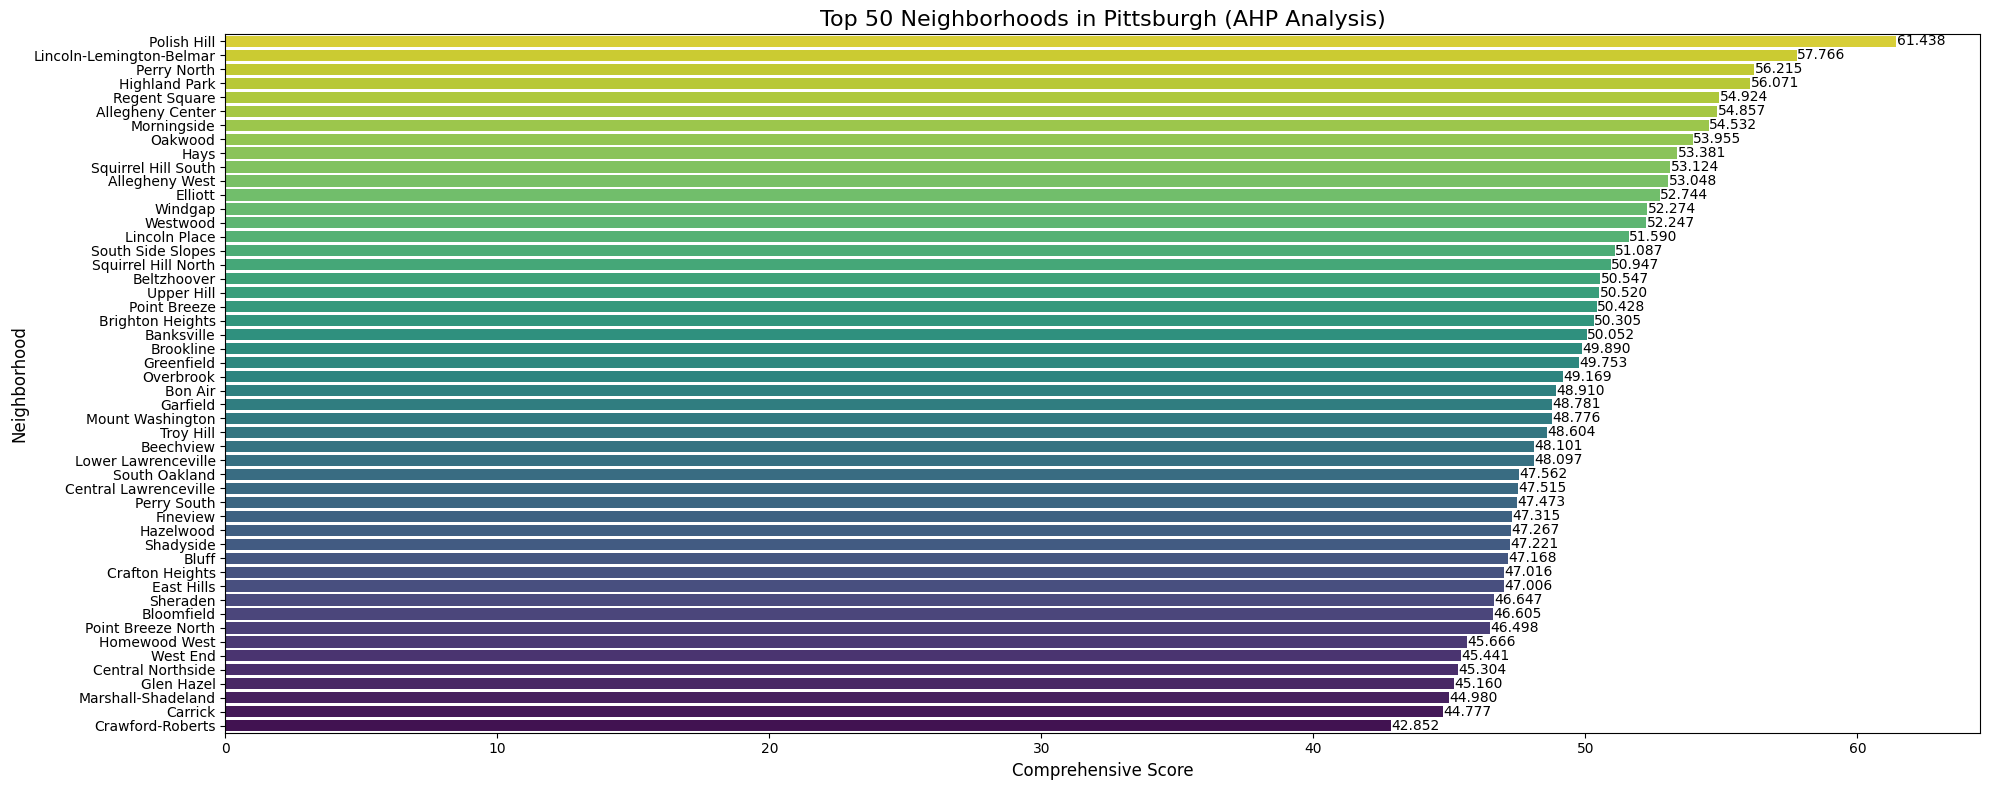

<Figure size 640x480 with 0 Axes>

In [72]:
# Plot the bar chart for top 50 neighborhoods
top_50 = df_ranked.head(50)

plt.figure(figsize=(20, 8))
barplot = sns.barplot(x=top_50['Total_Score'], y=top_50.index, palette='viridis_r')

plt.title('Top 50 Neighborhoods in Pittsburgh (AHP Analysis)', fontsize=16)
plt.xlabel('Comprehensive Score', fontsize=12)
plt.ylabel('Neighborhood', fontsize=12)

for i, v in enumerate(top_50['Total_Score']):
    barplot.text(v + 0.01, i, f"{v:.3f}", va='center')

plt.tight_layout()
plt.show()
plt.savefig('outputs/Top_50_Neighborhoods_AHP_Barplot.png')

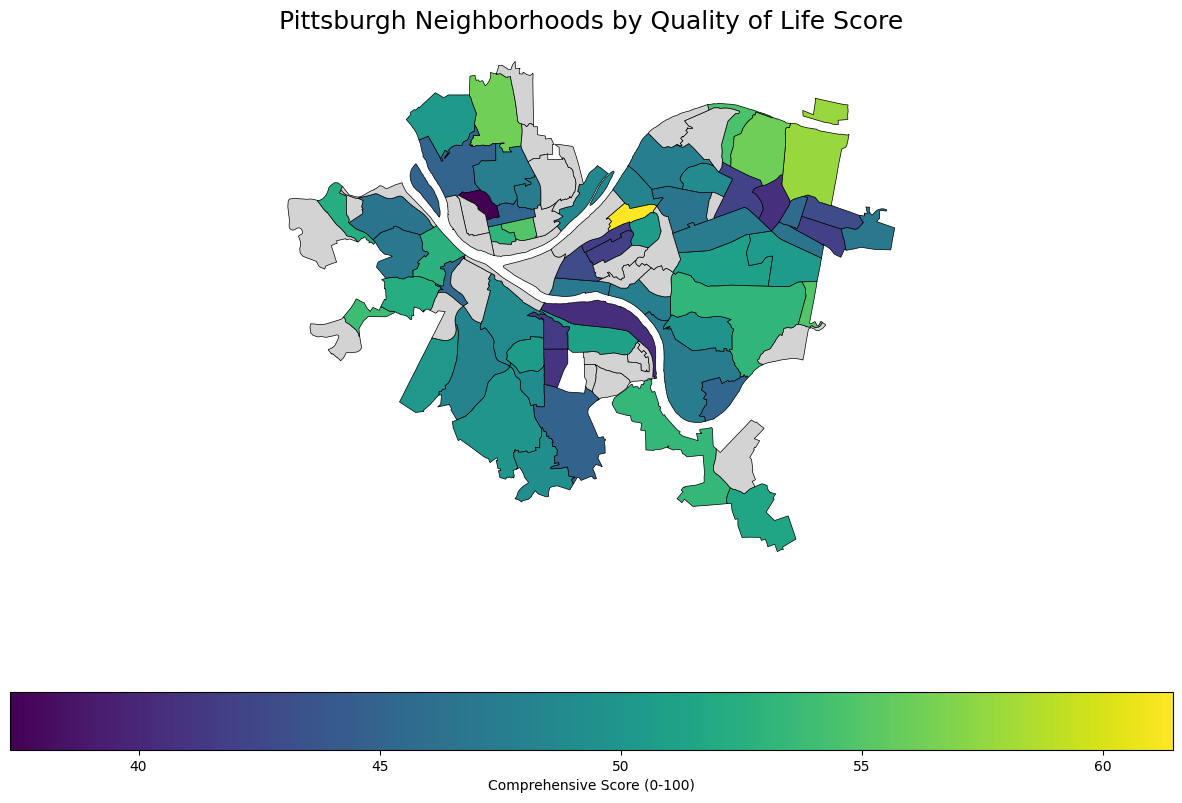

In [73]:
shapefile_path = "../data/Neighborhoods_shapefile/Neighborhoods_.shp"
neighborhoods = gpd.read_file(shapefile_path)
# Merge the geospatial data with the ranked scores
neighborhoods_map = neighborhoods.merge(df_ranked, how='left', left_on='hood', right_on='Neighborhood')
# Plotting the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

neighborhoods_map.plot(
    column='Total_Score',
    ax=ax,
    legend=True,
    cmap='viridis',   
    edgecolor='black',     
    linewidth=0.5,            
    legend_kwds={'label': "Comprehensive Score (0-100)", 'orientation': "horizontal"},
    missing_kwds={'color': 'lightgrey', 'label': 'No Data'} 
)

ax.set_title("Pittsburgh Neighborhoods by Quality of Life Score", fontsize=18)
ax.set_axis_off() #

plt.savefig("outputs/Pittsburgh_Neighborhood_Score_Map.png", dpi=300)
plt.show()


## Conclusion
